# Machine Learning of Hydrogen Bond Strength

This 

## Import packages

In [16]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, TensorDataset, random_split

## Read the data

In [2]:
# Read the data
DATA_FILENAME = "hbonddata.xlsx"
dataframe_raw = pd.read_excel(DATA_FILENAME,sheet_name='data')
dataframe_raw = dataframe_raw.filter(items=['Acid', 'Base', 'Agroup', 'Aeneg', 'Asize', 'Beneg', 'Bsize', 'Δν', '-ΔH (kJ mol-1)'])
# Drop the rows with NANs. 
dataframe_raw = dataframe_raw.dropna(axis=0, how = 'any')
dataframe_raw.head()

,Acid,Base,Agroup,Aeneg,Asize,Beneg,Bsize,Δν,-ΔH (kJ mol-1)
0,(CCl3)2CHOH,Acetonitrile,COH,3.41,150,2.90,166.0,211.0,22.6
1,(CH2Cl)2CHOH,Acetonitrile,COH,3.41,150,2.90,166.0,102.0,14.2
2,(CHCl2)2CHOH,Acetonitrile,COH,3.41,150,2.90,166.0,174.0,19.8
3,Acetic acid,Pyridine,COOH,3.41,150,2.90,166.0,1000.0,40.0
4,Acetic acid,Dimethyl sulfoxide,COOH,3.41,150,3.41,150.0,840.0,33.5


In [3]:
# Rename the columns
dataframe_raw.rename(columns={'-ΔH (kJ mol-1)': 'ΔH'}, inplace =True)
dataframe_raw.head()

,Acid,Base,Agroup,Aeneg,Asize,Beneg,Bsize,Δν,ΔH
0,(CCl3)2CHOH,Acetonitrile,COH,3.41,150,2.90,166.0,211.0,22.6
1,(CH2Cl)2CHOH,Acetonitrile,COH,3.41,150,2.90,166.0,102.0,14.2
2,(CHCl2)2CHOH,Acetonitrile,COH,3.41,150,2.90,166.0,174.0,19.8
3,Acetic acid,Pyridine,COOH,3.41,150,2.90,166.0,1000.0,40.0
4,Acetic acid,Dimethyl sulfoxide,COOH,3.41,150,3.41,150.0,840.0,33.5


In [4]:
# Check the info of the data
dataframe_raw.describe()

,Aeneg,Asize,Beneg,Bsize,Δν,ΔH
count,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000
mean,3.238428,155.789308,3.172390,157.122642,317.967614,19.464534
std,0.325150,10.909563,0.303832,8.586949,350.151747,11.840464
min,2.480000,150.000000,2.040000,150.000000,1.000000,0.700000
25%,3.410000,150.000000,2.900000,150.000000,109.192487,10.632760
50%,3.410000,150.000000,3.410000,150.000000,218.741953,17.600000
75%,3.410000,150.000000,3.410000,166.000000,364.500000,25.104000
max,3.410000,189.000000,3.410000,177.000000,2300.000000,67.000000


In [5]:
your_name = "Lei-Lei-alpha machine learning h-bond strength" # at least 5 characters
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.85*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.Δν = dataframe.Δν * ord(rand_str[1])/100.
    # scale target
    dataframe.ΔH = dataframe.ΔH * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['Acid','Base'], axis=1)
    return dataframe

dataframe = customize_dataset(dataframe_raw, your_name)
dataframe

,Agroup,Aeneg,Asize,Beneg,Bsize,Δν,ΔH
135,NH,2.90,166,2.90,166.0,25.250000,8.085000
67,PhOH,3.41,150,3.41,150.0,341.380000,35.175000
163,C6Cl5OH,3.41,150,3.41,150.0,585.800000,32.970000
177,PhOH,3.41,150,3.41,150.0,595.900000,35.595000
136,NH,2.90,166,2.36,177.0,15.150000,6.720000
...,...,...,...,...,...,...,...
224,PhOH,3.41,150,2.90,166.0,687.810000,31.185000
171,COH,3.41,150,2.90,166.0,366.630000,28.140000
288,PhSH,2.69,189,2.36,177.0,20.200000,2.205000
91,COH,3.41,150,2.90,166.0,286.959735,16.869888


In [6]:
input_cols = ['Aeneg', 'Asize', 'Beneg', 'Bsize', 'Δν']
categorical_cols = ['Agroup']
output_cols = ['ΔH']

In [7]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

inputs_array, targets_array = dataframe_to_arrays(dataframe)
# inputs_array, targets_array

In [8]:
inputs = torch.Tensor(inputs_array)
targets = torch.Tensor(targets_array)

dataset = TensorDataset(inputs, targets)
train_ds, val_ds = random_split(dataset, [225, 45])
batch_size = 100

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [9]:
input_size = len(input_cols)
output_size = len(output_cols)
H = 30
criterion = nn.MSELoss(reduction='sum')
# p = 0.08
class HbondModel(nn.Module):
    def __init__(self):
        super().__init__()
#         self.linear = nn.Linear(input_size, output_size)                  # fill this (hint: use input_size & output_size defined above)
        self.input_linear = nn.Linear(input_size, H)
        self.middle_linear = nn.Linear(H, H)
        self.output_linear = nn.Linear(H, output_size)
#         self.dropout = nn.Dropout(p)
               
    def forward(self, xb):
        out = F.relu(self.input_linear(xb))
        out = F.relu(self.middle_linear(out))
        out = self.output_linear(out)
#         out = self.dropout(self.output_linear(out))
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = criterion(out, targets)                         # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = criterion(out, targets)                           # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 5 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [10]:
model = HbondModel()

# Eval algorithm
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

result = evaluate(model, val_loader)
print(result)

{'val_loss': 7132.88232421875}


In [11]:
# Fitting algorithm
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.AdamW):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [12]:
epochs = 20
lr = 1e-2
#     momentum=0.2
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [5], val_loss: 3003.9727
Epoch [10], val_loss: 986.1484
Epoch [15], val_loss: 836.9676
Epoch [20], val_loss: 811.1481


In [13]:
epochs = 10
#     momentum=0.1
lr = 1e-3
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [5], val_loss: 806.4670
Epoch [10], val_loss: 814.9759


In [17]:
# Prediction Algorithm
def validation(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()
    np.set_printoptions(suppress=True)
    print("Input:", input.numpy())
    print("Target:", target.numpy())
    print("Prediction:", prediction.numpy())
    return prediction

# Testing the model with some samples
input, target = val_ds[0]
validation(input, target, model)

Input: [  2.9  166.     3.41 150.   158.57]
Target: [13.86]
Prediction: [15.119172]


tensor([15.1192])

In [18]:
val_value, target = val_ds[:]
predictions = validation(val_value, target, model)

Input: [[   2.9       166.          3.41      150.        158.57    ]
 [   3.41      150.          2.9       166.        431.27    ]
 [   3.41      150.          3.41      150.        303.      ]
 [   3.41      150.          3.41      150.        558.8157  ]
 [   3.41      150.          3.41      150.        331.01602 ]
 [   2.48      177.          2.9       166.          4.04    ]
 [   3.41      150.          3.41      150.        110.867645]
 [   3.41      150.          3.41      150.        271.69    ]
 [   2.48      177.          3.41      150.         12.12    ]
 [   2.48      177.          3.41      150.          6.06    ]
 [   3.41      150.          3.41      150.         74.74    ]
 [   2.9       166.          2.36      177.         15.15    ]
 [   3.41      150.          3.41      150.         81.489204]
 [   3.41      150.          3.41      150.        585.8     ]
 [   3.41      150.          2.9       166.        368.65    ]
 [   3.41      150.          3.41      150.     

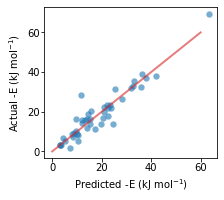

In [20]:
a = torch.linspace(0,60,20)
b = a
fig = plt.figure(figsize=(3.2,2.8))
ax = fig.add_axes([0.18, 0.18, 0.75, 0.75])
ax.scatter(predictions,target, c='tab:blue', s =40, linewidths=0, alpha = 0.6)
ax.plot(a,b, color='tab:red', lw = 2, alpha = 0.6)
ax.tick_params(axis='x', pad=1.2)
ax.tick_params(axis='y', pad=1.2)
ax.set_xlabel('Predicted -E (kJ mol$^{-1}$)')
ax.set_ylabel('Actual -E (kJ mol$^{-1}$)')
# plt.savefig('modeleva6_AdomW1.jpg',dpi=600)
plt.show()

In [34]:
# Prediction Algorithm
def predict(values, model):
    inputs = values.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()
    print("The input values are:", inputs.numpy()[0])
    print("The H bond energy is:", prediction.numpy()[0], 'kJ/mol')
    return prediction

In [28]:
values = torch.tensor([2.9, 166, 2.74, 204, 145])
predict(values, model)

The input values are: [  2.9  166.     2.74 204.   145.  ]
The H bond energy is: 15.752947807312012 kJ/mol


tensor([15.7529])

In [29]:
# Save the model
save_path = './h-bond-mode_AdomW.pth'
torch.save(model.state_dict(), save_path)

In [31]:
# Loading the model
hmodel = HbondModel()
hmodel.load_state_dict(torch.load(save_path))
hmodel.eval()

HbondModel(
  (input_linear): Linear(in_features=5, out_features=30, bias=True)
  (middle_linear): Linear(in_features=30, out_features=30, bias=True)
  (output_linear): Linear(in_features=30, out_features=1, bias=True)
)

In [38]:
values = torch.tensor([2.9, 166, 2.74, 204, 145])
predicts=predict(values, hmodel)
print(values[-1].item(), predicts.item())

The input values are: [  2.9  166.     2.74 204.   145.  ]
The H bond energy is: 15.752948 kJ/mol
145.0 15.752947807312012


In [37]:
values = torch.tensor([[2.9, 166, 2.74, 204, 145],
                      [   3.4100,  150.0000,    2.9000,  166.0000,  350.2602],
                      [   2.9000,  166.0000,    3.4100,  150.0000,  265.6400],
                      [   3.4100,  150.0000,    2.9000,  166.0000,  281.5720],
                      [   3.4100,  150.0000,    3.4100,  150.0000,   87.0000],
                      [   3.4100,  150.0000,    3.4100,  150.0000,  237.8000],
                      [   2.4800,  177.0000,    2.9000,  166.0000,   85.8400],
                      [   2.4800,  177.0000,    3.4100,  150.0000,   82.3600],
                      [   3.4100,  150.0000,    2.9000,  166.0000,  329.5775]])
# values=values[:]
predicts=predict(values, hmodel)
print(predicts.numpy())

The input values are: [[  2.9    166.       2.74   204.     145.    ]
 [  3.41   150.       2.9    166.     350.2602]
 [  2.9    166.       3.41   150.     265.64  ]
 [  3.41   150.       2.9    166.     281.572 ]
 [  3.41   150.       3.41   150.      87.    ]
 [  3.41   150.       3.41   150.     237.8   ]
 [  2.48   177.       2.9    166.      85.84  ]
 [  2.48   177.       3.41   150.      82.36  ]
 [  3.41   150.       2.9    166.     329.5775]]
The H bond energy is: [15.752949] kJ/mol
[[15.752949]
 [24.49957 ]
 [21.12299 ]
 [21.205343]
 [10.141448]
 [18.951523]
 [10.02996 ]
 [ 9.272145]
 [23.507647]]


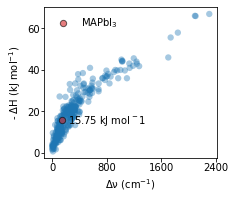

In [51]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(3.2,2.8))
ax = fig.add_axes([0.18, 0.18, 0.75, 0.75])
ax.scatter(dataframe_raw.Δν, dataframe_raw.ΔH, c='tab:blue', s =40, alpha = 0.4, linewidths=0)
ax.scatter(values[-1], predicts, color='tab:red', s =40, alpha = 0.6, edgecolors='k', label='MAPbI$_3$')
ax.tick_params(axis='x', pad=1.2)
ax.tick_params(axis='y', pad=1.2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(800))
ax.text(800, 15.5,  f'{"%.2f" % predicts.item()} kJ mol$^{-1}$', ha='center', va = 'center')
ax.set_xlabel('Δν (cm$^{-1}$)')
ax.set_ylabel('- ΔH (kJ mol$^{-1}$)')
plt.legend(frameon=False)
# plt.savefig('v-h plot.jpg',dpi=600)
plt.show()